In [1]:
sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))


import pandas as pd
from pathlib import Path
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

import sys, os

import matplotlib.pyplot as plt

# Accuracy score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.neighbors import KNeighborsRegressor


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import ConfusionMatrixDisplay

In [2]:

def remove_missing_values(fuel_df, drop_smog=True, rating_column='co2_rating', drop_column='smog_rating'):

    # Drop smog_rating from non_na_rating
    if drop_smog:
        fuel_df.drop(columns=[drop_column], inplace=True)
    else:
        pass
    fuel_df['number_of_gears'].fillna(0, inplace=True)

    # Set up data pipeline - goal is to predict co2_rating 
    na_rating = fuel_df[fuel_df[rating_column].isna()]
    non_na_rating = fuel_df[~fuel_df[rating_column].isna()]

    non_na_rating_class = non_na_rating.copy()
    na_rating_class = na_rating.copy()

    non_na_rating_class[rating_column] = non_na_rating_class[rating_column].astype(int)

    return non_na_rating_class, na_rating_class

def read_data(path):
    """
    This function reads data from csv files

    Parameters:
    ----------
        path: str
            path to data files

    Returns:
    -------
        fuel_df: pandas.DataFrame
            dataframe containing fuel cars data
        electric_df: pandas.DataFrame
            dataframe containing electric cars data
        hybrid_df: pandas.DataFrame
            dataframe containing hybrid cars data

    """
    
    # Fuel based cars
    file_name_2022_1995 = "1995_today_vehicle_fuel_consumption.csv"
    
    # Electric cars
    pure_electric = "Batteryelectric_vehicles__.csv"
    hybric_vehicle = "Plugin_hybrid_electric_vehicles__.csv"

    # Read data files
    fuel_df = pd.read_csv(Path(path ,f'{file_name_2022_1995}'))
    electric_df = pd.read_csv(Path(path ,f'{pure_electric}'))
    hybrid_df = pd.read_csv(Path(path ,f'{hybric_vehicle}'))

    return fuel_df, electric_df, hybrid_df

fuel_df, electric_df, hybrid_df = read_data('../data/clean-data/')

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_pipeline, model_name):
    
    model_pipeline.fit(X_train, y_train.values.ravel())


    # Predict
    y_pred = model_pipeline.predict(X_test)
    
    # Obtain accuracy score
    acc = accuracy_score(y_test, y_pred)
    print('accuracy is',accuracy_score(y_pred,y_test))
    
    score_train = model_pipeline.score(X_train, y_train)
    score_test = model_pipeline.score(X_test, y_test)
    print('score for training set', score_train, 'score for testing set', score_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy score", balanced_accuracy)
    
    report = classification_report(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    _ = ax.set_title(
        f"Confusion Matrix for {model_name}"
    )
    
    plt.show()
    
    print(report, sep=',')

def classify_grid_search_cv_tuning(model, parameters, X_train, X_test, y_train, y_test, n_folds = 5, scoring='accuracy'):
    """
    This function tunes GridSearchCV model
    
    Parameters:
    ----------
        model
        parameters
        X_train
        X_test
        y_train
        y_test
        n_folds
        scoring
        
    Returns:
    --------
        best_model
        best_score
    """
    # Set up and fit model
    tune_model = GridSearchCV(model, param_grid=parameters, cv=n_folds, scoring=scoring)
    tune_model.fit(X_train, y_train)
    
    best_model = tune_model.best_estimator_
    best_score = tune_model.best_score_
    y_pred = best_model.predict(X_test)
    
    # Printing results
    print("Best parameters:", tune_model.best_params_)
    print("Cross-validated accuracy score on training data: {:0.4f}".format(tune_model.best_score_))
    print()

    print(classification_report(y_test, y_pred))
    
    return best_model, best_score

Hybrid vehicles

In [3]:
non_na_rating_class, na_rating_class = remove_missing_values(hybrid_df)

In [4]:
non_na_rating_class['consumption_combinedle/100km']

20     2.8 ([25.2 kWh + 0.0 L]/100 km)
21     2.7 ([23.9 kWh + 0.0 L]/100 km)
22     3.3 ([29.1 kWh + 0.0 L]/100 km)
23               2.0 (17.9 kWh/100 km)
24     3.1 ([26.9 kWh + 0.2 L]/100 km)
                    ...               
239    3.0 ([27.2 kWh + 0.0 L]/100 km)
240    3.4 ([30.0 kWh + 0.0 L]/100 km)
241    3.0 ([27.2 kWh + 0.0 L]/100 km)
242    3.5 ([31.2 kWh + 0.0 L]/100 km)
243    3.8 ([34.4 kWh + 0.0 L]/100 km)
Name: consumption_combinedle/100km, Length: 224, dtype: object

In [5]:
non_na_rating_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 20 to 243
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   model_year                     224 non-null    int64  
 1   make_                          224 non-null    object 
 2   model.1_                       224 non-null    object 
 3   vehicleclass_                  224 non-null    object 
 4   motor_(kw)                     224 non-null    int64  
 5   enginesize_(l)                 224 non-null    float64
 6   cylinders_                     224 non-null    float64
 7   transmission_                  224 non-null    object 
 8   fuel_type1                     224 non-null    object 
 9   consumption_combinedle/100km   224 non-null    object 
 10  range1_(km)                    224 non-null    int64  
 11  recharge_time(h)               224 non-null    float64
 12  fuel_type2                     224 non-null    ob

In [6]:
# Var list
hybrid_var_list = ['vehicleclass_','make_',
                    'model.1_','model_year',
                    'cylinders_','fuelconsumption_city(l/100km)',
                    'fuelconsumption_hwy(l/100km)',
                    'fuelconsumption_comb(l/100km)',
                    'fuel_type1',
                    'fuel_type2',
                    'co2emissions_(g/km)',
                    'number_of_gears']

# Set up parameters for the model - numerical and categorical
numeric_features =  ['model_year','cylinders_',
                    'fuelconsumption_city(l/100km)',
                    'fuelconsumption_hwy(l/100km)',
                    'fuelconsumption_comb(l/100km)',
                    'co2emissions_(g/km)','number_of_gears']
categorical_features = ['vehicleclass_']

# Set up numerical and categorical transformers
numeric_transformer = Pipeline(
                            steps=[("scaler", StandardScaler())]
                        )

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Set up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        #("cat", categorical_transformer, categorical_features),
    ]
)


In [7]:
Y = non_na_rating_class[['co2_rating']]

# Dependent variables
X = non_na_rating_class[hybrid_var_list]

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    

In [9]:
# Set up pipeline
# Set up parameters for the model - numerical and categorical
numeric_features =  numeric_features
categorical_features = categorical_features

# Set up preprocessor
preprocessor = preprocessor

In [10]:
# # Use smote to balance the data
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train[numeric_features], y_train)


(array([  2.,   0.,  16.,   0.,   0.,  26.,   0.,  40.,   0., 140.]),
 array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 10 artists>)

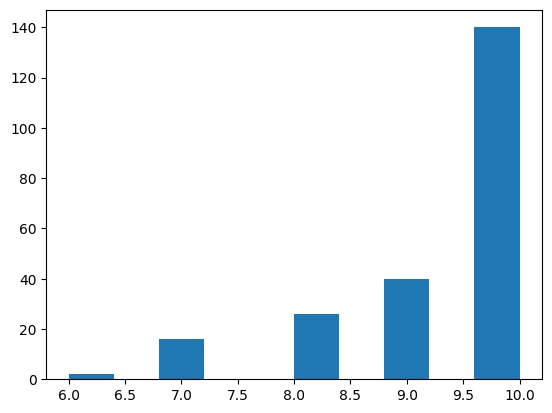

In [11]:
import seaborn as sns
plt.hist(x=non_na_rating_class['co2_rating'])

Random Forest
accuracy is 0.8666666666666667
score for training set 0.994413407821229 score for testing set 0.8666666666666667
Balanced accuracy score 0.8323809523809524


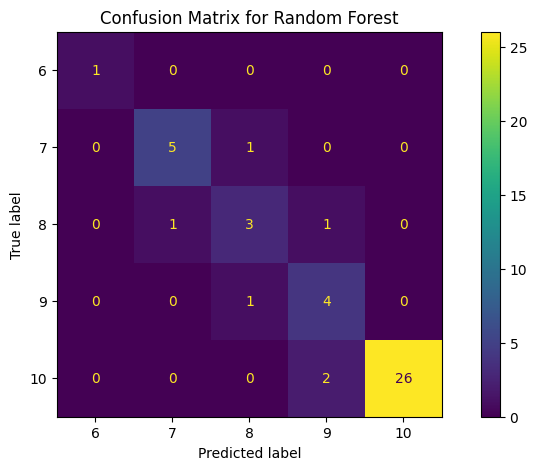

              precision    recall  f1-score   support

           6       1.00      1.00      1.00         1
           7       0.83      0.83      0.83         6
           8       0.60      0.60      0.60         5
           9       0.57      0.80      0.67         5
          10       1.00      0.93      0.96        28

    accuracy                           0.87        45
   macro avg       0.80      0.83      0.81        45
weighted avg       0.89      0.87      0.87        45

----------------


In [12]:
names = [
    "Random Forest",
]

classifiers = [
    RandomForestClassifier(max_depth=100, n_estimators=10, max_features=1, random_state=42),
]


for name, clf in zip(names, classifiers):
    print(name)
    
    model = Pipeline(
        steps=[("preprocessor", preprocessor), (name, clf, )] #colsample  by tree, n estimators, max depth
                                                                    )
    train_and_evaluate_model(X_train, y_train, X_test, y_test, model,name)
    
    print("----------------")

In [13]:
model.get_params().values()

dict_values([None, [('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['model_year', 'cylinders_',
                                  'fuelconsumption_city(l/100km)',
                                  'fuelconsumption_hwy(l/100km)',
                                  'fuelconsumption_comb(l/100km)',
                                  'co2emissions_(g/km)', 'number_of_gears'])])), ('Random Forest', RandomForestClassifier(max_depth=100, max_features=1, n_estimators=10,
                       random_state=42))], False, ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['model_year', 'cylinders_',
                                  'fuelconsumption_city(l/100km)',
                                  'fuelconsumption_hwy(l/100km)',
                                  'fuelconsu

In [70]:
params = {'Random Forest__max_depth': range(1, 10),
           'Random Forest__max_features': ['auto', 'sqrt', 'log2'],
           'Random Forest__max_leaf_nodes': range(1, 10),
           'Random Forest__max_samples': range(1, 10),
           'Random Forest__n_estimators': range(10, 100) ,
           'Random Forest__min_samples_leaf': range(1, 100),}

best_dtc, dtc_score = classify_grid_search_cv_tuning(model, params, X_train, X_test, y_train, y_test, n_folds=5, scoring='f1_weighted')